--- EXECUTANDO EM MODO COMPLETO ---
Validando e limpando dados...
Aviso: Valores inválidos encontrados nos dados para a chave '10'. Realizando limpeza...
Aviso: Valores inválidos encontrados nos dados para a chave '9.5'. Realizando limpeza...
Aviso: Valores inválidos encontrados nos dados para a chave '9'. Realizando limpeza...
Aviso: Valores inválidos encontrados nos dados para a chave '8.5'. Realizando limpeza...
Aviso: Valores inválidos encontrados nos dados para a chave '8'. Realizando limpeza...
Aviso: Valores inválidos encontrados nos dados para a chave '7.5'. Realizando limpeza...
Aviso: Valores inválidos encontrados nos dados para a chave '7'. Realizando limpeza...
Aviso: Valores inválidos encontrados nos dados para a chave '6.5'. Realizando limpeza...
Aviso: Valores inválidos encontrados nos dados para a chave '6'. Realizando limpeza...
Aviso: Valores inválidos encontrados nos dados para a chave '5.5'. Realizando limpeza...
Aviso: Valores inválidos encontrados nos dados para a

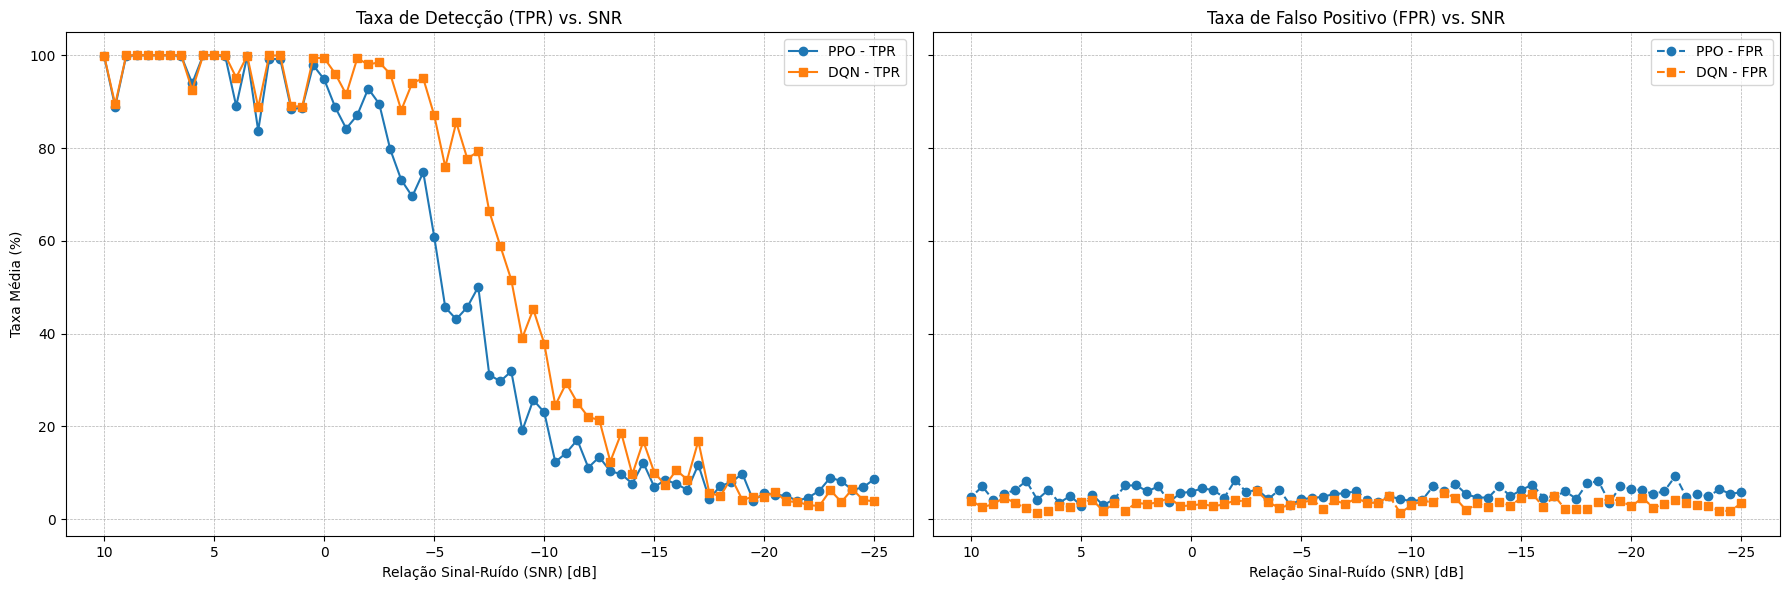

In [26]:
# -*- coding: utf-8 -*-
"""
Notebook Refatorado v14 para Comparação de Modelos de RL.

Esta versão modifica a seção de plotagem para gerar gráficos separados
para as métricas TPR e FPR, melhorando a clareza e a visualização
dos resultados da avaliação em dados simulados.
"""

# %% [markdown]
# # Comparação de Modelos de RL (Versão 14)
# 
# Este notebook treina, avalia em dados simulados e, por fim, avalia com retreinamento dois modelos de Aprendizado por Reforço (PPO, DQN).

# %% [code]
# Importações essenciais
import pickle
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import matplotlib.pyplot as plt

# %% [markdown]
# ## Parâmetros de Controle

# %% [code]
# #####################################################################
# MODO DE EXECUÇÃO: DRY RUN (TESTE RÁPIDO) OU EXECUÇÃO COMPLETA
# #####################################################################
DRY_RUN = False # Mude para False para uma execução completa

# #####################################################################
# PARÂMETROS GLOBAIS
# #####################################################################
if DRY_RUN:
    print("--- EXECUTANDO EM MODO DRY RUN (TESTE RÁPIDO) ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 1000, 500
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 1, 1
else:
    print("--- EXECUTANDO EM MODO COMPLETO ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = (120 - 2) * 17 * 50, 5000
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 5, 10

# %% [code]
# Carregamento dos dados de estados
with open('c_states_dict_acer_v3.pkl', 'rb') as f:
    c_states_simulado = pickle.load(f)
with open('c_states_dict_exp_filt.pkl', 'rb') as f:
    c_states_experimental = pickle.load(f)

# %% [markdown]
# ## Validação e Limpeza dos Dados

# %% [code]
def clean_data_dict(data_dict):
    """Itera por um dicionário de arrays e remove NaNs/infs."""
    for key, array in data_dict.items():
        if np.isnan(array).any() or np.isinf(array).any():
            print(f"Aviso: Valores inválidos encontrados nos dados para a chave '{key}'. Realizando limpeza...")
            data_dict[key] = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)
    return data_dict

print("Validando e limpando dados...")
c_states_simulado = clean_data_dict(c_states_simulado)
c_states_experimental = clean_data_dict(c_states_experimental)
print("Validação completa.")
    
# %% [code]
# FUNÇÃO DE NORMALIZAÇÃO
def my_norm(val, min_val=0, max_val=3): return (val - min_val) / (max_val - min_val)

# %% [code]
class CustomLoggingCallback(BaseCallback):
    def __init__(self, log_freq: int, verbose=0):
        super().__init__(verbose)
        self.log_freq, self.episode_count = log_freq, 0
    def _on_step(self) -> bool:
        if any(self.locals["dones"]):
            self.episode_count += 1
            if self.episode_count % self.log_freq == 0 and self.logger.name_to_value:
                print(f"--- Logs da Biblioteca (Episódio {self.episode_count}) ---")
                for key, value in self.logger.name_to_value.items():
                    print(f"  {key}: {value:.4f}")
                print("---------------------------------------")
        return True

class SimTrainingEnv(gym.Env):
    def __init__(self, data, verbose_level=0, verbose_freq=10):
        super().__init__()
        self.data, self.verbose_level, self.verbose_freq = data, verbose_level, verbose_freq
        self.episodes, self.frequencies, self.measures, self.windows = data.shape[0]-1, data.shape[1]-1, data.shape[2], data.shape[3]-1
        self.action_space, self.observation_space = spaces.Discrete(2), spaces.Box(low=0, high=1, shape=(4 * self.measures,), dtype=np.float32)
        self.episode_count = -1
        self.reset()
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.episode_count += 1
        self.current_episode = self.episode_count % (self.episodes + 1)
        self.current_window, self.current_frequency = 2, 0
        self.false_positives, self.true_positives = 0, 0
        self.tpr_hist, self.fpr_hist = [], []
        return self._get_state(), {'tp_rate': np.nan, 'fp_rate': np.nan}
    def step(self, action):
        should_detect = self.current_frequency <= 8
        tp,fp,fn,tn = 0,0,0,0
        if action==1:
            if should_detect: self.true_positives+=1; tp=1
            else: self.false_positives+=1; fp=1
        else:
            if should_detect: fn=1
            else: tn=1
        reward = tp - fp - fn + tn
        self.current_frequency += 1
        terminated, info = False, {}
        if self.current_frequency > self.frequencies:
            tp_rate = 100 * self.true_positives / (self.frequencies//2+1)
            fp_rate = 100 * self.false_positives / (self.frequencies//2+1)
            self.tpr_hist.append(tp_rate); self.fpr_hist.append(fp_rate)
            self.current_window += 1
            self.current_frequency, self.true_positives, self.false_positives = 0,0,0
            if self.current_window > self.windows:
                terminated = True
                mean_tpr = np.mean(self.tpr_hist) if self.tpr_hist else 0
                mean_fpr = np.mean(self.fpr_hist) if self.fpr_hist else 0
                reward = ((mean_tpr**2)/100) - ((mean_fpr**2)/100)
                info = {'tp_rate': round(mean_tpr,2), 'fp_rate': round(mean_fpr,2)}
                if self.verbose_level > 0 and self.episode_count % self.verbose_freq == 0:
                    print(f"--- Resumo do Ambiente (Episódio {self.episode_count}) ---")
                    print(f"  TPR Final: {info.get('tp_rate',0):.2f}%, FPR Final: {info.get('fp_rate',0):.2f}%, Recompensa Final: {reward:.2f}")
        return self._get_state(), reward, terminated, False, info
    def _get_state(self):
        safe_window_idx = min(self.current_window, self.windows)
        focus = self.data[self.current_episode, self.current_frequency, :, safe_window_idx]
        noise_indices = np.setdiff1d(np.arange(9, 17), self.current_frequency - 9 if self.current_frequency >= 9 else [])
        noise_freqs = np.random.choice(noise_indices, 3, replace=False)
        noises = [self.data[self.current_episode, nf, :, safe_window_idx] for nf in noise_freqs]
        return np.array(my_norm(np.concatenate(([focus], noises), axis=0).flatten()), dtype=np.float32)

class ExpEvaluationEnv(gym.Env):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.frequencies, self.measures, self.windows = data.shape[0]-1, data.shape[1], data.shape[2]-1
        self.action_space, self.observation_space = spaces.Discrete(2), spaces.Box(low=0, high=1, shape=(4*self.measures,), dtype=np.float32)
        self.current_window = -1
        self.reset()
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_window = (self.current_window + 1) % (self.windows + 1)
        self.current_frequency, self.true_positives, self.false_positives = 0,0,0
        return self._get_state(), self._get_info()
    def step(self, action):
        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect: self.true_positives += 1
            else: self.false_positives += 1
        self.current_frequency += 1
        terminated = self.current_frequency > self.frequencies
        reward = 1 if (action==1 and should_detect) or (action==0 and not should_detect) else -1
        return self._get_state(), reward, terminated, False, self._get_info() if terminated else {}
    def _get_state(self):
        freq_idx = min(self.current_frequency, self.frequencies)
        focus = self.data[freq_idx, :, self.current_window]
        noise_indices = np.setdiff1d(np.arange(9, 17), freq_idx - 9 if freq_idx >= 9 else [])
        noise_freqs = np.random.choice(noise_indices, 3, replace=False)
        noises = [self.data[nf, :, self.current_window] for nf in noise_freqs]
        return np.array(my_norm(np.concatenate(([focus], noises), axis=0).flatten()), dtype=np.float32)
    def _get_info(self):
        tp_rate = 100 * self.true_positives / 9
        fp_rate = 100 * self.false_positives / 8 if self.false_positives > 0 else 0
        return {'tp_rate': tp_rate, 'fp_rate': fp_rate}

# %% [markdown]
# # 1. Treinamento Inicial dos Modelos
# %% [code]
def train_model(model_class, policy, data, timesteps, model_name, v_level, v_freq, log_freq):
    print(f"--- Treinando modelo {model_class.__name__} ---")
    env = DummyVecEnv([lambda: SimTrainingEnv(data, verbose_level=v_level, verbose_freq=v_freq)])
    net_arch = dict(pi=[8], vf=[8]) if model_class == PPO else [8]
    policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=net_arch)
    model = model_class(policy, env, verbose=0, policy_kwargs=policy_kwargs)
    model.learn(total_timesteps=timesteps, callback=CustomLoggingCallback(log_freq=log_freq))
    model.save(model_name)
    print(f"Modelo salvo como {model_name}\n")
snr_treino = 0
dados_treino = c_states_simulado[snr_treino]
train_model(PPO, 'MlpPolicy', dados_treino, TOTAL_TIMESTEPS_TREINO, 'modelo_ppo.zip', VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ)
train_model(DQN, 'MlpPolicy', dados_treino, TOTAL_TIMESTEPS_TREINO, 'modelo_dqn.zip', VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ)

# %% [markdown]
# # 2. Avaliação em Dados Simulados (vs. SNR)
# %% [code]
def evaluate_on_sim_data(model, data, total_timesteps):
    env = SimTrainingEnv(data)
    obs, _ = env.reset()
    tpr_list, fpr_list = [], []
    for _ in range(total_timesteps):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, _, info = env.step(action)
        if terminated:
            if 'tp_rate' in info and not np.isnan(info['tp_rate']):
                tpr_list.append(info['tp_rate']); fpr_list.append(info['fp_rate'])
            obs, _ = env.reset()
    if not tpr_list: return np.nan, np.nan
    return np.nanmean(tpr_list), np.nanmean(fpr_list)
results = {"PPO": {"tpr": [], "fpr": []}, "DQN": {"tpr": [], "fpr": []}}
modelos_para_teste = {"PPO": "modelo_ppo.zip", "DQN": "modelo_dqn.zip"}
snr_list = sorted(c_states_simulado.keys())
if DRY_RUN: snr_list = [snr for snr in snr_list if snr in [0, -10]]
print("--- Avaliando modelos em dados SIMULADOS ---")
for snr in snr_list:
    print(f"Avaliando SNR: {snr} dB")
    for nome, arquivo in modelos_para_teste.items():
        model = (PPO.load(arquivo) if nome == "PPO" else DQN.load(arquivo))
        tpr, fpr = evaluate_on_sim_data(model, c_states_simulado[snr], EVAL_SIM_TIMESTEPS)
        results[nome]["tpr"].append(tpr); results[nome]["fpr"].append(fpr)

# **NOVA SEÇÃO DE PLOTAGEM**
# Cria uma figura com dois subplots (1 linha, 2 colunas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# --- Plot 1: Taxa de Detecção (TPR) ---
ax1.plot(snr_list, results["PPO"]["tpr"], 'o-', label='PPO - TPR')
ax1.plot(snr_list, results["DQN"]["tpr"], 's-', label='DQN - TPR')
ax1.set_title('Taxa de Detecção (TPR) vs. SNR')
ax1.set_xlabel('Relação Sinal-Ruído (SNR) [dB]')
ax1.set_ylabel('Taxa Média (%)')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend()
ax1.invert_xaxis()

# --- Plot 2: Taxa de Falso Positivo (FPR) ---
ax2.plot(snr_list, results["PPO"]["fpr"], 'o--', label='PPO - FPR', color='C0') # C0 = Azul (mesma cor do PPO)
ax2.plot(snr_list, results["DQN"]["fpr"], 's--', label='DQN - FPR', color='C1') # C1 = Laranja (mesma cor do DQN)
ax2.set_title('Taxa de Falso Positivo (FPR) vs. SNR')
ax2.set_xlabel('Relação Sinal-Ruído (SNR) [dB]')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.legend()
ax2.invert_xaxis()

# Ajusta o layout e salva a figura
plt.tight_layout()
plt.savefig('performance_vs_snr_v14.png')
print(f"\nGráfico 'performance_vs_snr_v14.png' foi salvo.")

# %% [markdown]
# # 3. Avaliação com Retreinamento em Dados Experimentais
# %% [code]
def evaluate_on_exp_data(model, data):
    env = ExpEvaluationEnv(data)
    tpr_list, fpr_list = [], []
    for _ in range(data.shape[2]):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _, info = env.step(action)
        tpr_list.append(info['tp_rate']); fpr_list.append(info['fp_rate'])
    return np.mean(tpr_list), np.mean(fpr_list)
intensidades_map = {70:(4,1), 60:(4,2), 50:(4,3), 40:(4,4), 30:(4,5)}
if DRY_RUN: intensidades_map = {70:(4,1), 40:(4,4)}
print("\n--- Avaliando modelos em dados EXPERIMENTAIS com retreinamento ---")
for nome, arquivo in modelos_para_teste.items():
    print(f"--- Processando Modelo: {nome} ---")
    for intensidade_db, data_key in intensidades_map.items():
        dados_exp = c_states_experimental[data_key]
        dados_retreino, dados_avaliacao = dados_exp[:, :, :1], dados_exp[:, :, 1:]
        model = PPO.load(arquivo) if nome == "PPO" else DQN.load(arquivo)
        env_retreino = DummyVecEnv([lambda: ExpEvaluationEnv(dados_retreino)])
        model.set_env(env_retreino)
        model.learn(total_timesteps=dados_retreino.shape[0])
        tpr, fpr = evaluate_on_exp_data(model, dados_avaliacao)
        print(f"  Intensidade {intensidade_db} dB -> TPR: {tpr:.2f}%, FPR: {fpr:.2f}%")
    print("-" * 40)

In [ ]:
# -*- coding: utf-8 -*-
"""
Notebook Refatorado v14 para Comparação de Modelos de RL.

Esta versão modifica a seção de plotagem para gerar gráficos separados
para as métricas TPR e FPR, melhorando a clareza e a visualização
dos resultados da avaliação em dados simulados.
"""

# %% [markdown]
# # Comparação de Modelos de RL (Versão 14)
# 
# Este notebook treina, avalia em dados simulados e, por fim, avalia com retreinamento dois modelos de Aprendizado por Reforço (PPO, DQN).

# %% [code]
# Importações essenciais
import pickle
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import matplotlib.pyplot as plt

# %% [markdown]
# ## Parâmetros de Controle

# %% [code]
# #####################################################################
# MODO DE EXECUÇÃO: DRY RUN (TESTE RÁPIDO) OU EXECUÇÃO COMPLETA
# #####################################################################
DRY_RUN = False # Mude para False para uma execução completa

# #####################################################################
# PARÂMETROS GLOBAIS
# #####################################################################
if DRY_RUN:
    print("--- EXECUTANDO EM MODO DRY RUN (TESTE RÁPIDO) ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 1000, 500
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 1, 1
else:
    print("--- EXECUTANDO EM MODO COMPLETO ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = (120 - 2) * 17 * 50, 5000
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 5, 10

# %% [code]
# Carregamento dos dados de estados
with open('c_states_dict_acer_v3.pkl', 'rb') as f:
    c_states_simulado = pickle.load(f)
with open('c_states_dict_exp_filt.pkl', 'rb') as f:
    c_states_experimental = pickle.load(f)

# %% [markdown]
# ## Validação e Limpeza dos Dados

# %% [code]
def clean_data_dict(data_dict):
    """Itera por um dicionário de arrays e remove NaNs/infs."""
    for key, array in data_dict.items():
        if np.isnan(array).any() or np.isinf(array).any():
            print(f"Aviso: Valores inválidos encontrados nos dados para a chave '{key}'. Realizando limpeza...")
            data_dict[key] = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)
    return data_dict

print("Validando e limpando dados...")
c_states_simulado = clean_data_dict(c_states_simulado)
c_states_experimental = clean_data_dict(c_states_experimental)
print("Validação completa.")
    
# %% [code]
# FUNÇÃO DE NORMALIZAÇÃO
def my_norm(val, min_val=0, max_val=3): return (val - min_val) / (max_val - min_val)

# %% [code]
class CustomLoggingCallback(BaseCallback):
    def __init__(self, log_freq: int, verbose=0):
        super().__init__(verbose)
        self.log_freq, self.episode_count = log_freq, 0
    def _on_step(self) -> bool:
        if any(self.locals["dones"]):
            self.episode_count += 1
            if self.episode_count % self.log_freq == 0 and self.logger.name_to_value:
                print(f"--- Logs da Biblioteca (Episódio {self.episode_count}) ---")
                for key, value in self.logger.name_to_value.items():
                    print(f"  {key}: {value:.4f}")
                print("---------------------------------------")
        return True

class SimTrainingEnv(gym.Env):
    def __init__(self, data, verbose_level=0, verbose_freq=10):
        super().__init__()
        self.data, self.verbose_level, self.verbose_freq = data, verbose_level, verbose_freq
        self.episodes, self.frequencies, self.measures, self.windows = data.shape[0]-1, data.shape[1]-1, data.shape[2], data.shape[3]-1
        self.action_space, self.observation_space = spaces.Discrete(2), spaces.Box(low=0, high=1, shape=(4 * self.measures,), dtype=np.float32)
        self.episode_count = -1
        self.reset()
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.episode_count += 1
        self.current_episode = self.episode_count % (self.episodes + 1)
        self.current_window, self.current_frequency = 2, 0
        self.false_positives, self.true_positives = 0, 0
        self.tpr_hist, self.fpr_hist = [], []
        return self._get_state(), {'tp_rate': np.nan, 'fp_rate': np.nan}
    def step(self, action):
        should_detect = self.current_frequency <= 8
        tp,fp,fn,tn = 0,0,0,0
        if action==1:
            if should_detect: self.true_positives+=1; tp=1
            else: self.false_positives+=1; fp=1
        else:
            if should_detect: fn=1
            else: tn=1
        reward = tp - fp - fn + tn
        self.current_frequency += 1
        terminated, info = False, {}
        if self.current_frequency > self.frequencies:
            tp_rate = 100 * self.true_positives / (self.frequencies//2+1)
            fp_rate = 100 * self.false_positives / (self.frequencies//2+1)
            self.tpr_hist.append(tp_rate); self.fpr_hist.append(fp_rate)
            self.current_window += 1
            self.current_frequency, self.true_positives, self.false_positives = 0,0,0
            if self.current_window > self.windows:
                terminated = True
                mean_tpr = np.mean(self.tpr_hist) if self.tpr_hist else 0
                mean_fpr = np.mean(self.fpr_hist) if self.fpr_hist else 0
                reward = ((mean_tpr**2)/100) - ((mean_fpr**2)/100)
                info = {'tp_rate': round(mean_tpr,2), 'fp_rate': round(mean_fpr,2)}
                if self.verbose_level > 0 and self.episode_count % self.verbose_freq == 0:
                    print(f"--- Resumo do Ambiente (Episódio {self.episode_count}) ---")
                    print(f"  TPR Final: {info.get('tp_rate',0):.2f}%, FPR Final: {info.get('fp_rate',0):.2f}%, Recompensa Final: {reward:.2f}")
        return self._get_state(), reward, terminated, False, info
    def _get_state(self):
        safe_window_idx = min(self.current_window, self.windows)
        focus = self.data[self.current_episode, self.current_frequency, :, safe_window_idx]
        noise_indices = np.setdiff1d(np.arange(9, 17), self.current_frequency - 9 if self.current_frequency >= 9 else [])
        noise_freqs = np.random.choice(noise_indices, 3, replace=False)
        noises = [self.data[self.current_episode, nf, :, safe_window_idx] for nf in noise_freqs]
        return np.array(np.concatenate(([focus], noises), axis=0).flatten(), dtype=np.float32)

class ExpEvaluationEnv(gym.Env):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.frequencies, self.measures, self.windows = data.shape[0]-1, data.shape[1], data.shape[2]-1
        self.action_space, self.observation_space = spaces.Discrete(2), spaces.Box(low=0, high=1, shape=(4*self.measures,), dtype=np.float32)
        self.current_window = -1
        self.reset()
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_window = (self.current_window + 1) % (self.windows + 1)
        self.current_frequency, self.true_positives, self.false_positives = 0,0,0
        return self._get_state(), self._get_info()
    def step(self, action):
        should_detect = self.current_frequency <= 8
        if action == 1:
            if should_detect: self.true_positives += 1
            else: self.false_positives += 1
        self.current_frequency += 1
        terminated = self.current_frequency > self.frequencies
        reward = 1 if (action==1 and should_detect) or (action==0 and not should_detect) else -1
        return self._get_state(), reward, terminated, False, self._get_info() if terminated else {}
    def _get_state(self):
        freq_idx = min(self.current_frequency, self.frequencies)
        focus = self.data[freq_idx, :, self.current_window]
        noise_indices = np.setdiff1d(np.arange(9, 17), freq_idx - 9 if freq_idx >= 9 else [])
        noise_freqs = np.random.choice(noise_indices, 3, replace=False)
        noises = [self.data[nf, :, self.current_window] for nf in noise_freqs]
        return np.array(my_norm(np.concatenate(([focus], noises), axis=0).flatten()), dtype=np.float32)
    def _get_info(self):
        tp_rate = 100 * self.true_positives / 9
        fp_rate = 100 * self.false_positives / 8 if self.false_positives > 0 else 0
        return {'tp_rate': tp_rate, 'fp_rate': fp_rate}

# %% [markdown]
# # 1. Treinamento Inicial dos Modelos
# %% [code]
def train_model(model_class, policy, data, timesteps, model_name, v_level, v_freq, log_freq):
    print(f"--- Treinando modelo {model_class.__name__} ---")
    env = DummyVecEnv([lambda: SimTrainingEnv(data, verbose_level=v_level, verbose_freq=v_freq)])
    net_arch = dict(pi=[8], vf=[8]) if model_class == PPO else [8]
    policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=net_arch)
    model = model_class(policy, env, verbose=0, policy_kwargs=policy_kwargs)
    model.learn(total_timesteps=timesteps, callback=CustomLoggingCallback(log_freq=log_freq))
    model.save(model_name)
    print(f"Modelo salvo como {model_name}\n")
snr_treino = 0
dados_treino = c_states_simulado[snr_treino]
train_model(PPO, 'MlpPolicy', dados_treino, TOTAL_TIMESTEPS_TREINO, 'modelo_ppo.zip', VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ)
train_model(DQN, 'MlpPolicy', dados_treino, TOTAL_TIMESTEPS_TREINO, 'modelo_dqn.zip', VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ)

# %% [markdown]
# # 2. Avaliação em Dados Simulados (vs. SNR)
# %% [code]
def evaluate_on_sim_data(model, data, total_timesteps):
    env = SimTrainingEnv(data)
    obs, _ = env.reset()
    tpr_list, fpr_list = [], []
    for _ in range(total_timesteps):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, _, info = env.step(action)
        if terminated:
            if 'tp_rate' in info and not np.isnan(info['tp_rate']):
                tpr_list.append(info['tp_rate']); fpr_list.append(info['fp_rate'])
            obs, _ = env.reset()
    if not tpr_list: return np.nan, np.nan
    return np.nanmean(tpr_list), np.nanmean(fpr_list)
results = {"PPO": {"tpr": [], "fpr": []}, "DQN": {"tpr": [], "fpr": []}}
modelos_para_teste = {"PPO": "modelo_ppo.zip", "DQN": "modelo_dqn.zip"}
snr_list = sorted(c_states_simulado.keys())
if DRY_RUN: snr_list = [snr for snr in snr_list if snr in [0, -10]]
print("--- Avaliando modelos em dados SIMULADOS ---")
for snr in snr_list:
    print(f"Avaliando SNR: {snr} dB")
    for nome, arquivo in modelos_para_teste.items():
        model = (PPO.load(arquivo) if nome == "PPO" else DQN.load(arquivo))
        tpr, fpr = evaluate_on_sim_data(model, c_states_simulado[snr], EVAL_SIM_TIMESTEPS)
        results[nome]["tpr"].append(tpr); results[nome]["fpr"].append(fpr)

# **NOVA SEÇÃO DE PLOTAGEM**
# Cria uma figura com dois subplots (1 linha, 2 colunas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# --- Plot 1: Taxa de Detecção (TPR) ---
ax1.plot(snr_list, results["PPO"]["tpr"], 'o-', label='PPO - TPR')
ax1.plot(snr_list, results["DQN"]["tpr"], 's-', label='DQN - TPR')
ax1.set_title('Taxa de Detecção (TPR) vs. SNR')
ax1.set_xlabel('Relação Sinal-Ruído (SNR) [dB]')
ax1.set_ylabel('Taxa Média (%)')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend()
ax1.invert_xaxis()

# --- Plot 2: Taxa de Falso Positivo (FPR) ---
ax2.plot(snr_list, results["PPO"]["fpr"], 'o--', label='PPO - FPR', color='C0') # C0 = Azul (mesma cor do PPO)
ax2.plot(snr_list, results["DQN"]["fpr"], 's--', label='DQN - FPR', color='C1') # C1 = Laranja (mesma cor do DQN)
ax2.set_title('Taxa de Falso Positivo (FPR) vs. SNR')
ax2.set_xlabel('Relação Sinal-Ruído (SNR) [dB]')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.legend()
ax2.invert_xaxis()

# Ajusta o layout e salva a figura
plt.tight_layout()
plt.savefig('performance_vs_snr_v14.png')
print(f"\nGráfico 'performance_vs_snr_v14.png' foi salvo.")

# %% [markdown]
# # 3. Avaliação com Retreinamento em Dados Experimentais
# %% [code]
def evaluate_on_exp_data(model, data):
    env = ExpEvaluationEnv(data)
    tpr_list, fpr_list = [], []
    for _ in range(data.shape[2]):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _, info = env.step(action)
        tpr_list.append(info['tp_rate']); fpr_list.append(info['fp_rate'])
    return np.mean(tpr_list), np.mean(fpr_list)
intensidades_map = {70:(4,1), 60:(4,2), 50:(4,3), 40:(4,4), 30:(4,5)}
if DRY_RUN: intensidades_map = {70:(4,1), 40:(4,4)}
print("\n--- Avaliando modelos em dados EXPERIMENTAIS com retreinamento ---")
for nome, arquivo in modelos_para_teste.items():
    print(f"--- Processando Modelo: {nome} ---")
    for intensidade_db, data_key in intensidades_map.items():
        dados_exp = c_states_experimental[data_key]
        dados_retreino, dados_avaliacao = dados_exp[:, :, :1], dados_exp[:, :, 1:]
        model = PPO.load(arquivo) if nome == "PPO" else DQN.load(arquivo)
        env_retreino = DummyVecEnv([lambda: ExpEvaluationEnv(dados_retreino)])
        model.set_env(env_retreino)
        model.learn(total_timesteps=dados_retreino.shape[0])
        tpr, fpr = evaluate_on_exp_data(model, dados_avaliacao)
        print(f"  Intensidade {intensidade_db} dB -> TPR: {tpr:.2f}%, FPR: {fpr:.2f}%")
    print("-" * 40)